# Amazon Fine Food Reviews Sentiment Analysis with Recurrent Neural Network

In [ ]:
import pandas as pd
import numpy as np
from collections import namedtuple
import tensorflow as tf
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import roc_curve, auc, classification_report

sns.set(color_codes=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


### Problem Statement

This is a supervised learning problem where we need to predict the positive or negative target variable for each review. The goal will be to maximize the accuracy of this classification.  We will train our model on a dataset containing thousands of reviews presented as unstructured text. Each review will be labeled as positive or negative.

To solve this problem we will perform the following tasks:
  1. Preprocess the data.
  2. Train and tune the hyperparameters of the recurrent neural network.
  3. Test the accuracy of the model on the testing set.

## Exploratory Data Analysis

Before building our recurrent neural network we will start by exploring our dataset. You can download the [Reviews.csv](https://www.kaggle.com/snap/amazon-fine-food-reviews) file from Kaggle. Let's start by loading the data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Reviews.csv")

How many reviews are included in this dataset?

In [ ]:
print("Number of reviews:",len(data))

Number of reviews: 568454


The dataset contains 568,454 food reviews Amazon users left from October 1999 to October 2012.

What are the fields provided in the Amazon fine food reviews dataset?

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


The review for a specific product by a specific user is stored in the Text column. The Text column consists of an unstructured text. In addition to the Text feature representing the review, we can identify the product using the ProductId feature, the Amazon user with the UserID feature, the date the review was posted by the Time column, and a brief summary of the review with the Summary variable. Additionally, HelpfulnessNumerator and HelpfulnessDenominator, two variables representing how helpful a review is, are also provided in the review.

More importantly, for each review, we have a “Score” variable representing a rating from 1 to 5 (1 is a poor review, and 5 is an excellent review).

### Sentiment Score

Here is the distribution of the score:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


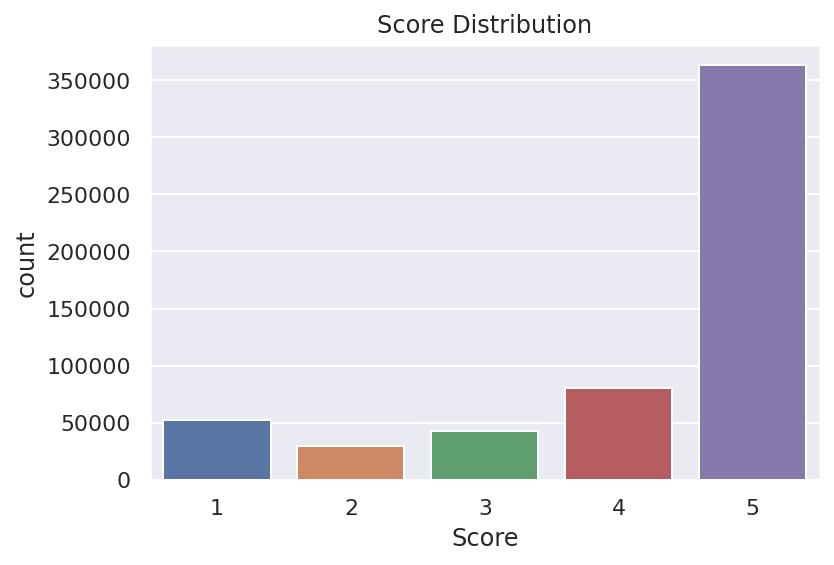

In [ ]:
ax = plt.axes()
sns.countplot(data.Score,ax=ax)
ax.set_title('Score Distribution')
plt.show()

In [ ]:
print("Average Score: ",np.mean(data.Score))
print("Median Score: ",np.median(data.Score))

Average Score:  4.183198640523243
Median Score:  5.0


As we can observe, the majority of Scores are equal to 4 and 5, and with an average score of 4.18. Because of the distribution is very skewed to the left, we will make a binary prediction. We can consider a negative review will have a Score between 1 and 3, and a positive review will have a Score equal to 4 or 5.

In [ ]:
data.loc[data.Score>3,'Sentiment']="POSITIVE"
data.loc[data.Score<=3,'Sentiment']="NEGATIVE"

After creating a new variable named Sentiment that is set to NEGATIVE when the Score is between 1 and 3, and POSITIVE when the Score is equal to 4 or 5, we get this new distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


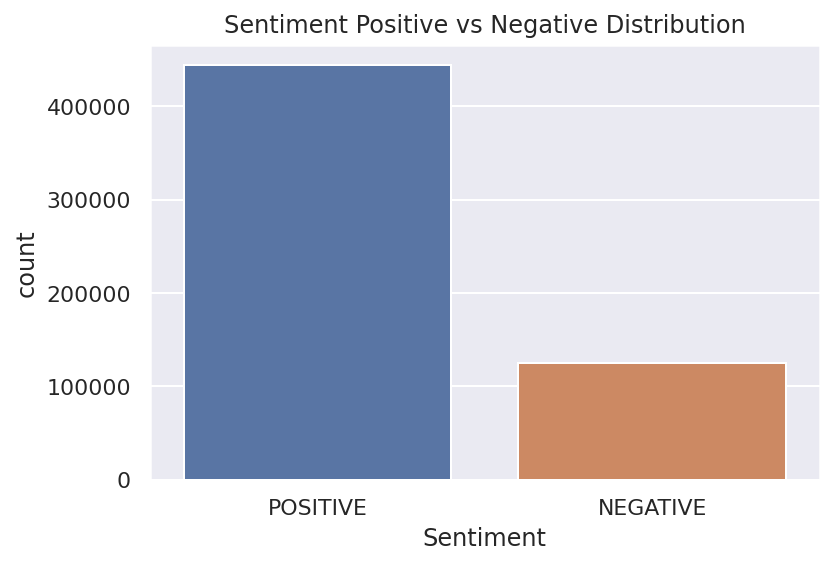

In [ ]:
ax = plt.axes()
sns.countplot(data.Sentiment,ax=ax)
ax.set_title('Sentiment Positive vs Negative Distribution')
plt.show()

In [ ]:
print("Proportion of positive review:", len(data[data.Sentiment=="POSITIVE"])/len(data))
print("Proportion of positive review:",len(data[data.Sentiment=="NEGATIVE"])/len(data))

Proportion of positive review: 0.7806735461444549
Proportion of positive review: 0.21932645385554503


With this new classification, 78% of the fine food reviews are considered as positive and 22% of them are considered as negative.

As we only need the Text field as an input for our model and the Sentiment (positive or negative) as an ouput, we will store this information in a reviews and sentiment variables.

In [ ]:
reviews = data.Text.values
labels = data.Sentiment.values

### Text Reviews

Now let's explore our input variable "text" which contains the review of the product.

In [ ]:
def pretty_print_review_and_label(i):
    if data.Sentiment[i]=="POSITIVE":
        print("POSITIVE" + "\t" + reviews[i][:90] + "...")
    else:
        print("NEGATIVE" + "\t " + reviews[i][:90] + "...")

In [ ]:
pretty_print_review_and_label(1)
pretty_print_review_and_label(4)
pretty_print_review_and_label(5)
pretty_print_review_and_label(50)

NEGATIVE	 Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized un...
POSITIVE	Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was v...
POSITIVE	I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoya...
NEGATIVE	 This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go....


The input variable is an unstructured text. By just looking at the first 90 characters, we can quickly have an idea of whether the review is positive or negative. For the negative reviews, we have negative expressions such as "not good", or "don't like it." These negative expressions can also be more nuanced depending on the context, such as "were actually small sized." For positive reviews, users use positive expression such as "Great taffy", "great price", "wide assortment", "yummy taffy", "very enjoyable," etc.

It's important to note that the text is unstructured, and we will have to do some pre-processing to remove punctuations, transform upper-case to lower case, etc.

### Exploratory Visualization

A common approach to distinguish positive from negative reviews is to look at the frequency of the words. We can imagine that certain words, such as "excellent" or "very tasty," tend to occur more often in positive reviews than negative reviews. Let's see if we can validate this theory.

In [ ]:
positive_reviews = [reviews[i] for i in range(len(reviews)) if labels[i]=="POSITIVE"]
negative_reviews = [reviews[i] for i in range(len(reviews)) if labels[i]=="NEGATIVE"]

In [ ]:
from collections import Counter

cnt_positve = Counter()

for row in positive_reviews:
    cnt_positve.update(row.split(" "))
print("Vocabulary size for positve reviews:", len(cnt_positve.keys()))

cnt_negative = Counter()

for row in negative_reviews:
    cnt_negative.update(row.split(" "))
print("Vocabulary size for positve reviews:", len(cnt_negative.keys()))

cnt_total = Counter()

for row in reviews:
    cnt_total.update(row.split(" "))
    

Vocabulary size for positve reviews: 480349
Vocabulary size for positve reviews: 239355


In [ ]:
pos_neg_ratio = Counter()
vocab_pos_neg = (set(cnt_positve.keys())).intersection(set(cnt_negative.keys()))
for word in vocab_pos_neg:
    if cnt_total[word]>100:
        ratio = cnt_positve[word]/float(cnt_negative[word]+1)
        if ratio>1:
            pos_neg_ratio[word] = np.log(ratio)
        else:
            pos_neg_ratio[word] = -np.log(1/(ratio+0.01)) 

After calculating the ratio between the frequency count in the positive review divided by the frequency count in the negative review for each word, here are the results:


When the ratio is high (greater than 1), it means than the words tend to occur more often in positive reviews than in negative reviews.


In [ ]:
pos_neg_ratio .most_common()[:30]

[('/>Highly', 5.791488055075306),
 ('anytime.', 5.147494476813453),
 ('soothing.', 4.912654885736052),
 ('addictive!', 4.897839799950911),
 ('Enjoy.', 4.840242308167575),
 ('/>Magnesium', 4.721470641684252),
 ('/>Almonds', 4.709530201312334),
 ('versatile.', 4.6443908991413725),
 ('Rich,', 4.634728988229636),
 ('organs.', 4.532599493153256),
 ('hooked.', 4.516338972281476),
 ('Delicious!', 4.496630017412885),
 ('diet?', 4.448516375942715),
 ('/>1st', 4.442651256490317),
 ('Cakesters', 4.382026634673881),
 ('Booda', 4.377851263263401),
 ('far!', 4.3694478524670215),
 ('*****<br', 4.3652195163575005),
 ('Favorites"', 4.33729074083249),
 ('Sciences', 4.33729074083249),
 ('synthesis.', 4.33729074083249),
 ('Highly', 4.3313052590894525),
 ('Chili<br', 4.31748811353631),
 ('addicted!', 4.310799125385514),
 ('plus!', 4.30406509320417),
 ('favorites!', 4.30406509320417),
 ('Delicious.', 4.298645025734831),
 ('Yummy!', 4.295015257684252),
 ('disappoint!', 4.283586561860629),
 ('recommended!', 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


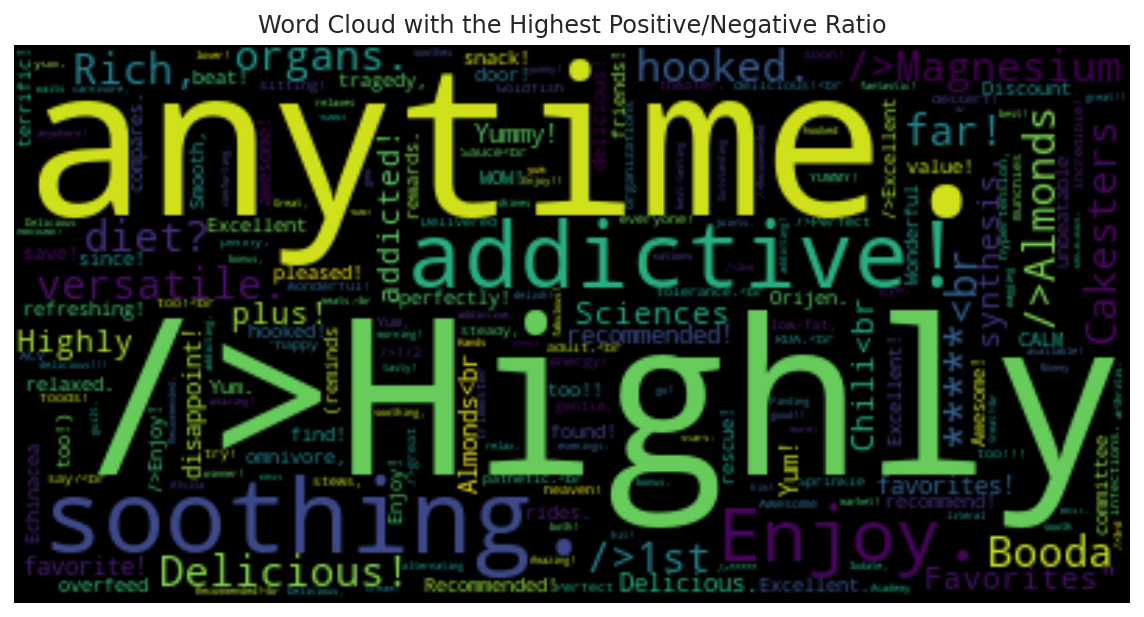

In [ ]:
positive_dict = {}
for word, cnt in pos_neg_ratio.items():
    if (cnt>1):
        positive_dict[word] = cnt

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=positive_dict)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
ax = plt.axes()
ax.set_title('Word Cloud with the Highest Positive/Negative Ratio')
plt.show()

In the word cloud above, some words that stand out are "highly", "addictive", "soothing", and "enjoy," which have a positive meaning. Certain ingredients or products are also highlighted like "chili", "magnesium", "almonds," etc. These word are neutral, but probably appear often in positive reviews as a result of Amazon's inventory; Amazon likely selects to distribute products, like almonds or chili, that meet or surpass users' expectations.


Let's look now at the words that tend to occur more often in negative reviews than in positive reviews.

In [ ]:
list(reversed(pos_neg_ratio.most_common()))[0:30]

[('FREAKS', -4.203010866014426),
 ('factory)', -4.201364829298291),
 ('judgment,', -4.201364829298291),
 ('mistakes.<br', -3.914513666740598),
 ('howling,', -3.912023005428146),
 ('NO<br', -3.328075116833193),
 ('sad.<br', -3.248146207168314),
 ('Reducing', -3.2188758248682006),
 ('Lives,', -3.2188758248682006),
 ('slaughterhouse', -3.1778728512505374),
 ('ANYMORE.', -3.1424854222041994),
 ('(good,', -3.1088233633266724),
 ('mischief.', -3.101092789211817),
 ('blue)', -2.9045009573244873),
 ('disappointment!', -2.8650573056222033),
 ('crying,', -2.7623992656292384),
 ('5/8', -2.745951587905034),
 ('"healthy,"', -2.7375866155346618),
 ('trashing', -2.6486357670125487),
 ('deliberately', -2.5174652359649476),
 ('returnable', -2.489919191611545),
 ('disorder.', -2.4825564724430467),
 ('Halo,', -2.4427317247372873),
 ('deceptive', -2.407945608651872),
 ('Horrible', -2.399007001651061),
 ('Buyer', -2.3765230838453015),
 ('twenty-five', -2.342112073137968),
 ('horrible!', -2.2335922215070942

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


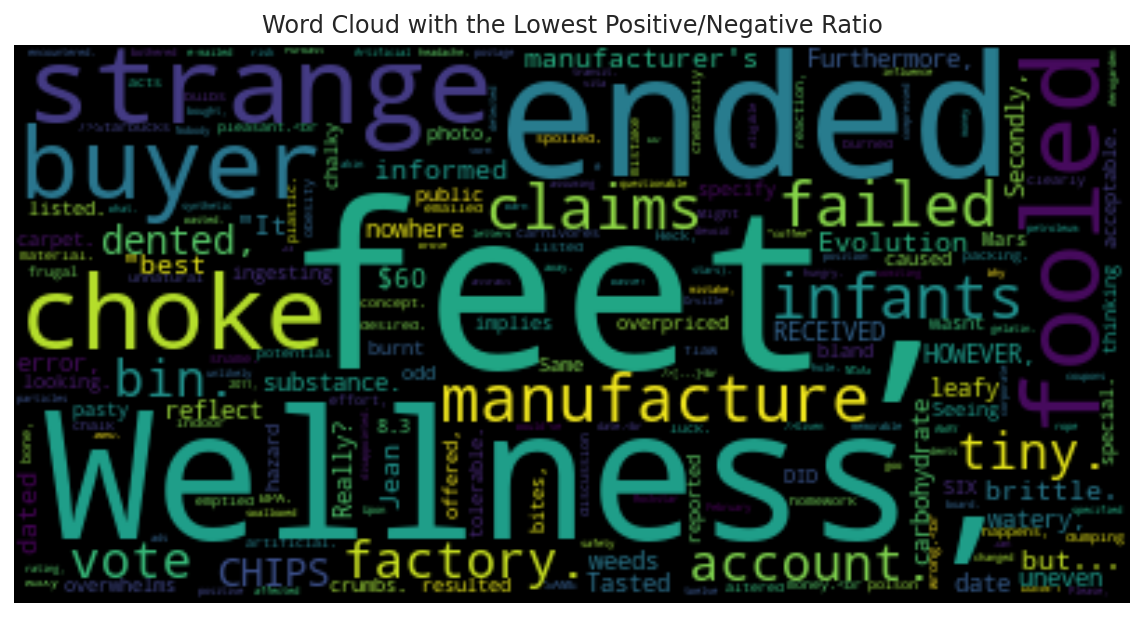

In [ ]:
negative_dict = {}
for word, cnt in pos_neg_ratio.items():
    if (cnt<1) & (cnt>0):
        negative_dict[word] = -np.log(cnt)

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=negative_dict)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
ax = plt.axes()
ax.set_title('Word Cloud with the Lowest Positive/Negative Ratio')
plt.show()

There are several negative words, such as "strange", "failed", "fooled", and "choke". However it's more difficult to understand why certain words like "wellness," "feet," and "buyer" appear more often in negative reviews.

## Algorithms and Techniques

In order to predict if a review is positive or negative we will use a recurrent neural network. Most of the methods for sentiment analysis look at each word individually, attribute positive points for positive words and negative points for negative words, and then total the points. This is the lexicon approach. However the problem with this method is that it ignores the sequence of the words, which can lead to the loss of important information. The RNN approach can understand subtleties because it doesn’t analyze text at face value. It creates abstract representations of what it learned.

We will use Long Short Term Memory Networks (LSTM), which is a special case of RNN. The main advantage of LSTM is that it can memorize information. When there's too large of a gap between two pieces of information, RNN is unable to learn to connect information. To learn more about LSTM, you can read this excellent  [article](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)  written by Christopher Olah.


#### Embedding
First we will use an embedding layer in order to represent words by a vectors. This representation is more efficient than one-hot encoding, especially in the actual context where the size of the vocabulary is more than 240,000 words.

To generate these embeddings, we will use the word2vec approach, so when words have similar meanings they will be close to each other.

The word2vec approach is based on the assumption that similar words happen in similar context. By using this method, we are able to determine some semantic relationships, like, for example, the fact that a man and a king are male, or that a woman and a queen are female. 

#### Long Short Term Memory
The next step is to pass the embedded words to the LSTM cells. In the graph, you can observe that there are connections between the first, second and third LSTM cells. In contrast to other models that assume that all the inputs are independent of each other, these connections here allow us to pass information contained in the sequence of words. One of the strengths of the LSTM cell is the ability to add or remove information to the cell state.


#### Output: positive or negative?
Finally, we will predict if the review is positive or negative using the sigmoid function. The advantage of the function is that it's bound between 0 and 1 and can be interpreted as a probability of success. For example, we can estimate the probability that a review is positive. At each step, we have an output. However, we only care about the final output that predicts the sentiment at the end of the sentence.

#### Tuning hyperparameters

For our recurrent neural network we will have to tune the following hyperparameters:

Optimizer hyperparameters:
  - Learning rate
  - Minibatch size
  - Number of epochs

Model hyperparameters:
  - Number of hidden layers (LSTM layers)
  - Number of units in the LSTM cells
  - Dropout rate

## Data Preprocessing

In order to train our model, we had to transform the reviews into the right format. We performed the following steps:


In [ ]:
reviews = data.Text.values
labels = np.array([1 if s=="POSITIVE" else 0 for s in data.Sentiment.values])

First we need to remove punctuations and transform all the characters into a list of integers.

In [ ]:
reviews_cleaned = []
for i in range(len(reviews)):
    reviews_cleaned.append(''.join([c.lower() for c in reviews[i] if c not in punctuation]))

In [ ]:
print("Before: ",reviews[0])
print("")
print("After: ",reviews_cleaned[0])

Before:  I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

After:  i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than  most


What's the size of the vocabulary after removing punctuations and transform characters to lower case?

In [ ]:
vocabulary = set(' '.join(reviews_cleaned).split())
print("Vocabulary size: ", len(vocabulary))

Vocabulary size:  240772


## Noise reduction by reducing vocabulary

Let's create a vocabulary reduction function in case we want to reduce the vocabulary based on min frequency or polarity.

In [ ]:
def vocabulary_reduction(reviews,min_freq=10,polarity_cut_off=0.1):
    
    pos_count = Counter()
    neg_count = Counter()
    tot_count = Counter()

    for i in range(len(reviews)):
        for word in reviews[i].split():
            tot_count[word]+=1
            if labels[i] == 1:
                pos_count[word]+=1
            else:
                neg_count[word]+=1    
    
    #Identify words with frequency greater than min_freq
    vocab_freq = []
    for word in tot_count.keys():
        if tot_count[word]>min_freq:
            vocab_freq.append(word)  
    
    #Use polarity to reduce vocab
    pos_neg_ratio = Counter()
    vocab_pos_neg = (set(pos_count.keys())).intersection(set(neg_count.keys()))
    for word in vocab_pos_neg:
        if tot_count[word]>100:
            ratio = pos_count[word]/float(neg_count[word]+1)
            if ratio>1:
                pos_neg_ratio[word] = np.log(ratio)
            else:
                pos_neg_ratio[word] = -np.log(1/(ratio+0.01)) 
    
    mean_ratio = np.mean(list(pos_neg_ratio.values()))
    
    vocab_polarity = []
    for word in pos_neg_ratio.keys():
        if (pos_neg_ratio[word]<(mean_ratio-polarity_cut_off)) or (pos_neg_ratio[word]>(mean_ratio+polarity_cut_off)):
            vocab_polarity.append(word)
     
    vocab_rm_polarity = set(pos_neg_ratio.keys()).difference(vocab_polarity)
    vocab_reduced = (set(vocab_freq)).difference(set(vocab_rm_polarity))
 
    reviews_cleaned = []
    
    for review in reviews:
        review_temp = [word for word in review.split() if word in vocab_reduced]
        reviews_cleaned.append(' '.join(review_temp))
    
    return reviews_cleaned

In [ ]:
reviews_cleaned = vocabulary_reduction(reviews_cleaned,min_freq=0,polarity_cut_off=0)

Then we need to transform each review into a list of integers. First we can create a dictionary to map each word contained in vocabulary of the reviews to an integer.

In [ ]:
# Store all the text from each review in a text variable
text = ' '.join(reviews_cleaned)

# List all the vocabulary contained in the reviews
vocabulary = set(text.split(' '))

# Map each word to an integer
vocabulary_to_int = {word:i for i,word in enumerate(vocabulary,0)}

Once we have the vocabulary_to_int dictionary created, we can transform each review into a list of integers using the dictionary previously created.

In [ ]:
def reviews_to_integers(reviews):
    reviews_to_int = []
    for i in range(len(reviews)):
        to_int = [vocabulary_to_int[word] for word in reviews[i].split()]
        reviews_to_int.append(to_int)
    return reviews_to_int

reviews_to_int = reviews_to_integers(reviews_cleaned)

To train the RRN on the review dataset we have to create an array with 200 columns, and enough rows to fit one review per row. Then store each review consisting of integers in the array. If the number of words in the review is less than 200 words, we can pad the list with extra zeros. If the number of words in the review are more than 200 words then we can limit the review to the first 200 words.

In [ ]:
review_lengths = [len(review) for review in reviews_to_int]
print("Shortest review:", min(review_lengths))
print("Longest revies:",max(review_lengths))

Shortest review: 3
Longest revies: 3414


If we don't limit the review to 200 words, it will take too much time for the RRN to train. Here is the distribution of the review length:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

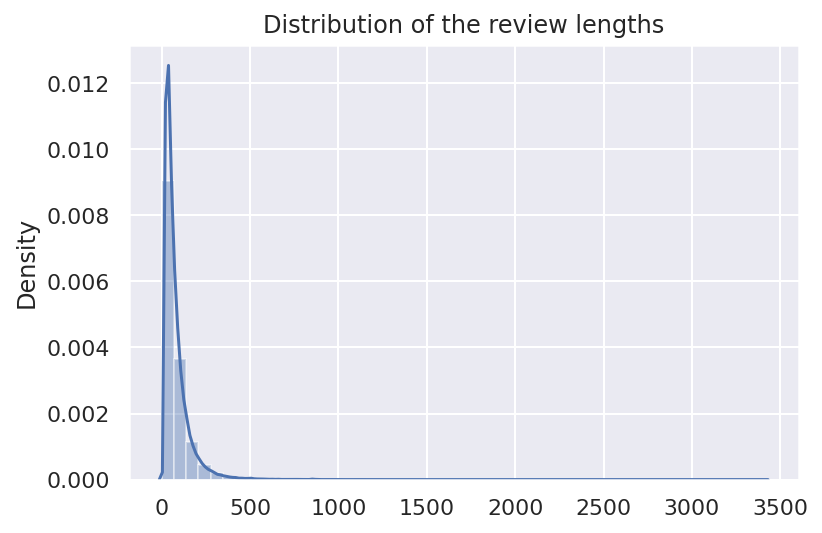

In [ ]:
ax = plt.axes()
sns.distplot(review_lengths)
ax.set_title("Distribution of the review lengths")
plt.plot()

In [ ]:
pd.DataFrame(review_lengths).describe()

,0
count,568454.000000
mean,79.913333
std,79.017418
min,3.000000
25%,33.000000
50%,56.000000
75%,97.000000
max,3414.000000


The mean and the third quartile of the review length is equal to 79 and 97, respectively.  Therefore if we limit the review length to 200 words, we shouldn't lose too much information.

In [ ]:
max_length = 200
features = np.zeros(shape=(len(reviews_to_int),max_length),dtype=int)

In [ ]:
for i in range(len(reviews_to_int)):
    nb_words = len(reviews_to_int[i])
    features[i] = [0]*(max_length -nb_words) + reviews_to_int[i][:200]

### Training, validation and split

In order to train our RNN model and evaluate it, it’s important to split the data into training, validation and testing datasets. We will train the model on a training set, and tune the model by validating the results on the validation dataset. Finally we will measure the ability of our model to generalize by testing our model on the testing dataset.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=5435)

splitter = sss.split(features, labels)
train_index, validation_index = next(splitter)
test_index = validation_index[:int(len(validation_index)/2)]
validation_index = validation_index[int(len(validation_index)/2):]

train_x, train_y = features[train_index], labels[train_index]
val_x, val_y = features[test_index], labels[test_index]
test_x, test_y = features[validation_index], labels[validation_index]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(454763, 200) 
Validation set: 	(56845, 200) 
Test set: 		(56846, 200)


### Build the LSTM model with Tensorflow
The next step is to build the recurrent neural network using the popular deep learning framework, Tensorflow.

To feed input, labels and keep_prob data into Tensorflow we need to first create placeholders.
```python
inputs_ = tf.placeholder(tf.int32,[None, None],name='inputs_')
labels_ = tf.placeholder(tf.int32,[None, None],name='labels_')
keep_prob = tf.placeholder(tf.float32,name='keep_prob')
```

Once we send the input data (the reviews) to Tensorflow, we want to transform each integer representing a word into a vector. As mentioned earlier, this method is called embedding.

```python
embedding = tf.Variable(tf.random_normal((n_words,embed_size),-1,1),name='embedding_')
embed = tf.nn.embedding_lookup(embedding,inputs_)
```

Then we need to create our LSTM cells and specify the number of hidden units in the LSTM cell.
```python
lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
```

It's always a good practice to add a Dropout layer to prevent the model from overfitting on the training set.
```python
drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)
```
By using tf.contrib.rnn.MultiRNNCell we can stack multiple LSTM layers. Usually in deep learning, the more hidden layers you have, the better the prediction will be.
```python
cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layer*)
```

We initialize all the states to zero.
```python
initial_state = cell.zero_state(batch_size, tf.float32)
```

Then we want to pass the input data through the LSTM cells. The output of each LSTM cell is carried to the next LSTM cell. This mechanism allow the recurrent neural network to memorize information.
```python
outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)
```

To get our prediction, we use a fully connected layer with a sigmoid function.
```python
predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1,
                                                activation_fn=tf.sigmoid,
                                                weights_initializer=
                                                tf.truncated_normal_initializer(stddev=0.1))
```

To measure the accuracy of our neural network, we need to define the cost function. For this problem, we will use the mean squared error.
```python
cost = tf.losses.mean_squared_error(labels_, predictions)
```
Finally, we want to minimize our cost function in order to make our network output as close as possible to the target values. For this project, we will use the Adam optimizer.
```python
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
```

In [ ]:
lstm_size = 256
lstm_layers = 1
batch_size = 500
learning_rate = 0.001
embed_size = 200 

In [ ]:
def build_rnn(vocabulary_to_int,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers):
    
    tf.reset_default_graph()
    
    n_words = len(vocabulary_to_int)
    
    with tf.name_scope('inputs'):
        inputs_ = tf.placeholder(tf.int32,[None, None],name='inputs_')
    with tf.name_scope('labels'):
        labels_ = tf.placeholder(tf.int32,[None, None],name='labels_')
    with tf.name_scope('keep_prob'):    
        keep_prob = tf.placeholder(tf.float32,name='keep_prob')
        
    with tf.name_scope('embedding'):
        embedding = tf.Variable(tf.random_normal((n_words,embed_size),-1,1),name='embedding_')
        embed = tf.nn.embedding_lookup(embedding,inputs_)
        
    with tf.name_scope("RNN_cells"):
        lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

        # Add dropout to the cell
        drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=keep_prob)

        # Stack up multiple LSTM layers, for deep learning
        cell = tf.contrib.rnn.MultiRNNCell([drop]*lstm_layers)
        
        with tf.name_scope("RNN_init_state"):
            # Getting an initial state of all zeros
            initial_state = cell.zero_state(batch_size, tf.float32)
    
    with tf.name_scope("RNN_forward"):
        outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)
        
    with tf.name_scope('predictions'):
        predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, 
                                                        activation_fn=tf.sigmoid,
                                                        weights_initializer=
                                                        tf.truncated_normal_initializer(stddev=0.1))   
    with tf.name_scope('cost'):
        cost = tf.losses.mean_squared_error(labels_, predictions)
        tf.summary.scalar('cost', cost)
    
    with tf.name_scope('train'):
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('accuracy'):
        correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    merged = tf.summary.merge_all()
    
    # Export the nodes 
    export_nodes = ['inputs_', 'labels_','initial_state', 'final_state',
                    'keep_prob', 'cell', 'cost', 'predictions', 'optimizer',
                    'accuracy','merged']
    
    Graph = namedtuple('Graph', export_nodes)
    
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In the code below, we are using tf.summary.FileWriter in order to be able to visualize in Tensorboard if our model has been built correctly.

In [ ]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [ ]:
graph = build_rnn(vocabulary_to_int,
              embed_size=embed_size,
              batch_size=batch_size,
              learning_rate=learning_rate,
              lstm_size=lstm_size,
              lstm_layers=lstm_layers)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('output/logs/1', sess.graph)

AttributeError: ignored

To train our model, we use the stochastic gradient descent approach. This method consists of calculating an estimate of the cost function on small batches of the dataset. This approach is more scalable than a traditional gradient descent.

In [ ]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [ ]:
epochs = 5

def train(model, epoch,train_writer,test_writer):
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        iteration = 1
        for e in range(epochs):
            state = sess.run(model.initial_state)

            for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
                feed = {model.inputs_: x,
                        model.labels_: y[:, None],
                        model.keep_prob: 0.5,
                        model.initial_state: state}
                summary,loss, state, _ = sess.run([model.merged,model.cost, 
                                                   model.final_state, 
                                                   model.optimizer], feed_dict=feed)

                if iteration%5==0:
                    print("Epoch: {}/{}".format(e, epochs),
                          "Iteration: {}".format(iteration),
                          "Train loss: {:.3f}".format(loss))

                train_writer.add_summary(summary, iteration)

                if iteration%25==0:
                    val_acc = []
                    val_state = sess.run(model.cell.zero_state(batch_size, tf.float32))
                    for x, y in get_batches(val_x, val_y, batch_size):
                        feed = {model.inputs_: x,
                                model.labels_: y[:, None],
                                model.keep_prob: 1,
                                model.initial_state: val_state}
                        summary, batch_acc, val_state = sess.run([model.merged,model.accuracy, 
                                                         model.final_state], feed_dict=feed)
                        val_acc.append(batch_acc)

                    test_writer.add_summary(summary,iteration)
                    print("Val acc: {:.3f}".format(np.mean(val_acc)))

                iteration +=1
        saver.save(sess, "output/checkpoints/sentiment.ckpt")

Then we can train our model on a single combination of parameters or we can test multiple combinations of hyperparameters.

In [ ]:
lstm_size_options = [256]
lstm_layers_options = [1]
learning_rate_options = [0.001]

#lstm_size_options = [128,256,512]
#lstm_layers_options = [1, 2]
#learning_rate_options = [0.002, 0.001]

In [ ]:
# Writer = tf.summary.create_file_writer(LOG_DIR)
# tf.summary.create_file_writer('log_path')
tf.compat.v1.reset_default_graph()
for lstm_size in lstm_size_options:
    for lstm_layers in lstm_layers_options:
        for learning_rate in learning_rate_options:
            log_string_train = 'output/logs/2/train/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            log_string_test = 'output/logs/2/test/lr={},rl={},ru={}'.format(learning_rate, lstm_layers, lstm_size)
            train_writer = tf.summary.create_file_writer(log_string_train)
            test_writer = tf.summary.create_file_writer(log_string_test)
            
            print("lstm size: {}".format(lstm_size),
                    "nb layers : {}".format(lstm_layers),
                    "learn rate : {:.3f}".format(learning_rate))

            model = build_rnn(vocabulary_to_int,
                      embed_size=embed_size,
                      batch_size=batch_size,
                      learning_rate=learning_rate,
                      lstm_size=lstm_size,
                      lstm_layers=lstm_layers)

            train(model, epochs, train_writer,test_writer)

In [ ]:
tf.train.get_checkpoint_state('output/checkpoints')

## Model Evaluation and Validation

The best way to see if our model is able to generalize is to test our model on the untouched testing set.

In [ ]:
test_acc = []
test_pred = []
test_label = []
    
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "output/checkpoints/sentiment.ckpt")
    test_state = sess.run(model.cell.zero_state(batch_size, tf.float32))
    
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {model.inputs_: x,
                model.labels_: y[:, None],
                model.keep_prob: 1,
                model.initial_state: test_state}
        batch_pred, batch_acc, test_state = sess.run([model.predictions,model.accuracy, model.final_state], feed_dict=feed)
        test_acc.append(batch_acc)
        test_pred = np.append(test_pred,batch_pred)
        test_label = np.append(test_label,y)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

 In order to measure the performance of the binary classifier, we can plot the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic). The ROC curve consists of plotting the true positive rate against the false positive rate. The best scenario is when the curve matches the left corner. This would mean that we are able to achieve 100% sensitivity (no false negatives) and 100% specificity (no false positives).

In [ ]:
fpr, tpr, _ = roc_curve(test_label, test_pred)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.plot(fpr, tpr, label='AUC %0.2f'%(roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.title("Receiver Operating Characteristics Curve")
plt.show()

We can observe that the area under the curve (AUC) is equal to 0.96. Knowing that the maximum AUC score is equal to 1, we can conclude that our model does a pretty good job at making accurate predictions on unseen reviews. Moreover our model seems to be very balanced in terms of false positive rate vs false negative rate.

The other important metric is the F1 score, because it also takes into consideration, precision and recall. In our original dataset 78% of the reviews were positive. If we would use a naive algorithm and predict that all the reviews are positive, our accuracy would be 78%. This is why we should use the F1 score in order to measure the performance of our RNN.

In [ ]:
print(classification_report(test_label, list(map(lambda x: round(x), test_pred))))

The final F1 score is equal to 0.92. The precision and recall are also equal to 0.92. It means once again that our model has a good balance between sensitivity and specificity. There is room for improvement but our RNN model has learned to distinguish negative fine food reviews from positive reviews.

## Conclusion


### Improvement

Deep Learning techniques tend to outperform every other algorithm when we get access to lots of data. So if we could train our model on a larger dataset, the model should definitely improve. With RNN, the model creates it's own representation of the sentence. The reviews contain vocabulary specific to the food product. If we had mode data, our model should be able to identify the specific characteristics that make a good product.
In order to improve this model, we should also investigate if we could include the product name/product type. If we had this information maybe our RNN would be able to more easily identify the important characteristics for each product.


-----------

https://www.tensorflow.org/tutorials/word2vec
